# Décomposition d'une série temporelle

Ce notebook présente quelques étapes simples pour une série temporelle. La plupart utilise le module [statsmodels.tsa](https://www.statsmodels.org/stable/tsa.html#module-statsmodels.tsa).

## Données

Les données sont artificielles mais simulent ce que pourraient être le chiffre d'affaires d'un magasin de quartier, des samedi très forts, une semaine morne, un Noël chargé, un été plat.

In [10]:
import pandas
from teachpyx.datasets.data_ts import generate_sells

df = pandas.DataFrame(generate_sells())
df.head()

,date,value
0,2023-03-06 00:39:51.820916,0.005036
1,2023-03-07 00:39:51.820916,0.004769
2,2023-03-08 00:39:51.820916,0.006293
3,2023-03-09 00:39:51.820916,0.006932
4,2023-03-10 00:39:51.820916,0.008666


## Premiers graphiques

La série a deux saisonnalités, hebdomadaire, mensuelle.

Text(0.5, 1.0, "chiffre d'affaire sur deux ans")

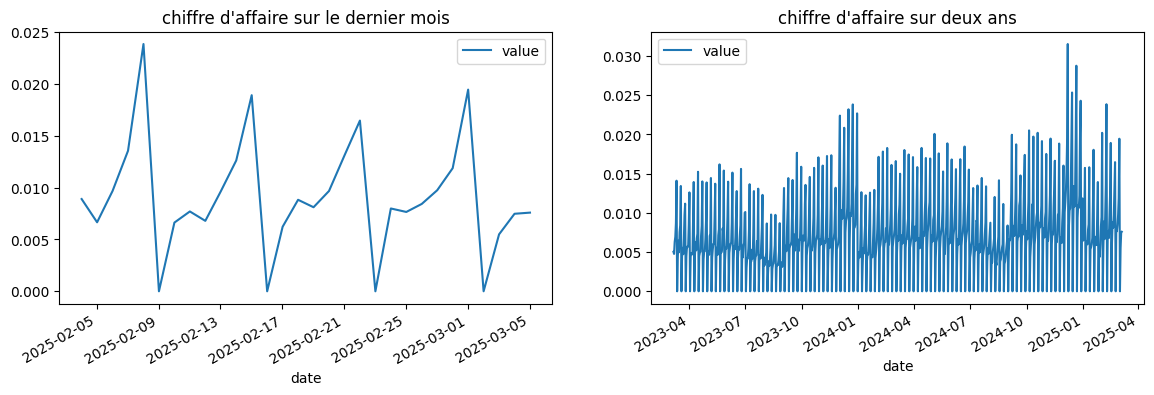

In [11]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(14, 4))
df.iloc[-30:].set_index("date").plot(ax=ax[0])
df.set_index("date").plot(ax=ax[1])
ax[0].set_title("chiffre d'affaire sur le dernier mois")
ax[1].set_title("chiffre d'affaire sur deux ans")

Elle a une vague tendance, on peut calculer un tendance à l'ordre 1, 2, ...

Text(0.5, 1.0, 'tendance')

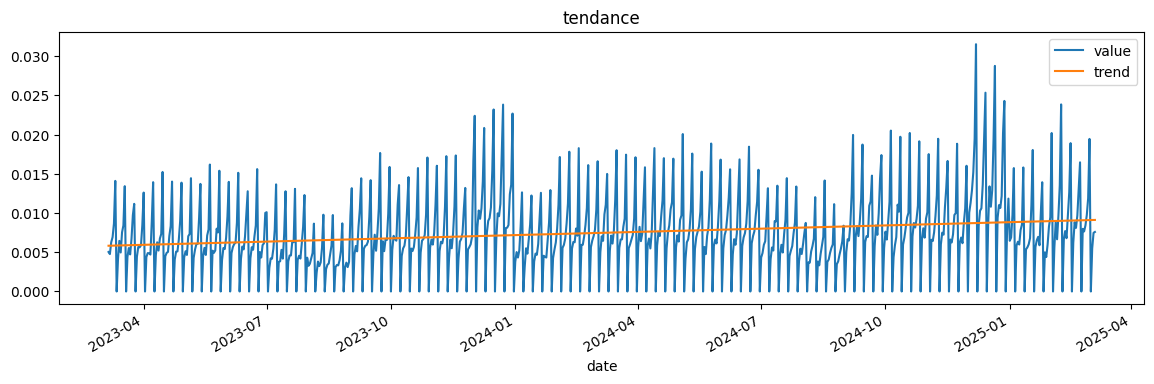

In [12]:
from statsmodels.tsa.tsatools import detrend

notrend = detrend(df.value, order=1)
df["notrend"] = notrend
df["trend"] = df["value"] - notrend
ax = df.plot(x="date", y=["value", "trend"], figsize=(14, 4))
ax.set_title("tendance")

Autocorrélations...

In [13]:
from statsmodels.tsa.stattools import acf

cor = acf(df.value)
cor

array([ 1.00000000e+00,  2.05522806e-02, -5.81441890e-02, -2.01231811e-02,
       -2.50535358e-02, -6.81166704e-02,  5.94423981e-04,  9.25077506e-01,
       -3.79860291e-03, -8.24593539e-02, -4.47874626e-02, -4.84700550e-02,
       -9.04852284e-02, -2.10021533e-02,  8.86200829e-01, -2.87651649e-02,
       -1.01244603e-01, -6.63494241e-02, -6.78568361e-02, -1.06899756e-01,
       -3.87558669e-02,  8.53901943e-01, -4.51168979e-02, -1.16356930e-01,
       -8.69970753e-02, -8.95201510e-02, -1.25409915e-01, -6.73383807e-02,
        8.10734998e-01])

Text(0.5, 1.0, 'Autocorrélogramme')

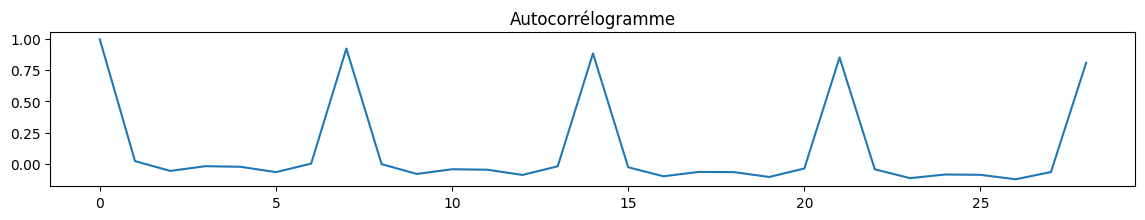

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(14, 2))
ax.plot(cor)
ax.set_title("Autocorrélogramme")

La première saisonalité apparaît, 7, 14, 21... Les autocorrélations partielles confirment cela, plutôt 7 jours.

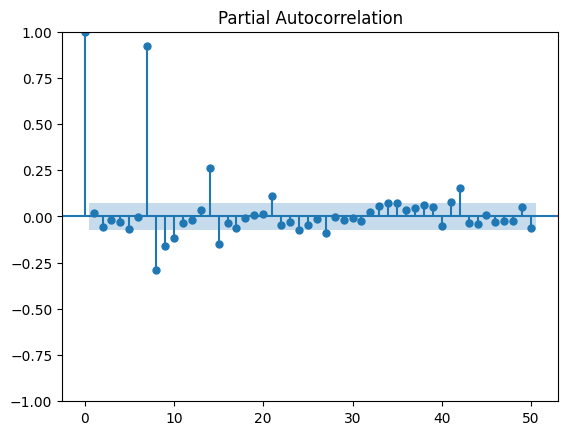

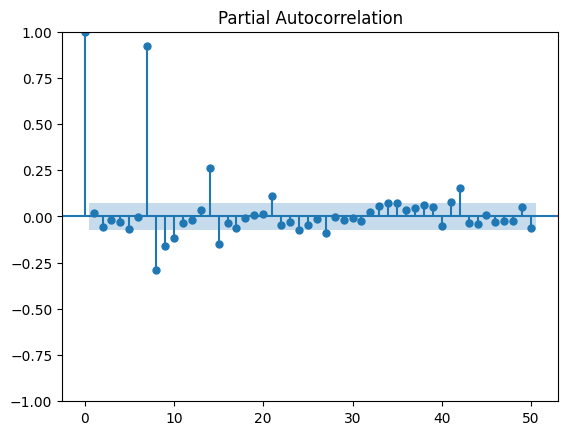

In [15]:
from statsmodels.tsa.stattools import pacf
from statsmodels.graphics.tsaplots import plot_pacf

plot_pacf(df.value, lags=50)

Comme il n'y a rien le dimanche, il vaut mieux les enlever. Garder des zéros nous priverait de modèles multiplicatifs.

In [16]:
df["weekday"] = df.date.dt.weekday
df.head()

,date,value,notrend,trend,weekday
0,2023-03-06 00:39:51.820916,0.005036,-0.000797,0.005833,0
1,2023-03-07 00:39:51.820916,0.004769,-0.001068,0.005837,1
2,2023-03-08 00:39:51.820916,0.006293,0.000451,0.005842,2
3,2023-03-09 00:39:51.820916,0.006932,0.001086,0.005846,3
4,2023-03-10 00:39:51.820916,0.008666,0.002815,0.005851,4


In [17]:
df_nosunday = df[df.weekday != 6]
df_nosunday.head(n=10)

,date,value,notrend,trend,weekday
0,2023-03-06 00:39:51.820916,0.005036,-0.000797,0.005833,0
1,2023-03-07 00:39:51.820916,0.004769,-0.001068,0.005837,1
2,2023-03-08 00:39:51.820916,0.006293,0.000451,0.005842,2
3,2023-03-09 00:39:51.820916,0.006932,0.001086,0.005846,3
4,2023-03-10 00:39:51.820916,0.008666,0.002815,0.005851,4
5,2023-03-11 00:39:51.820916,0.014102,0.008247,0.005855,5
7,2023-03-13 00:39:51.820916,0.004139,-0.001725,0.005864,0
8,2023-03-14 00:39:51.820916,0.006453,0.000584,0.005869,1
9,2023-03-15 00:39:51.820916,0.004974,-0.000900,0.005873,2
10,2023-03-16 00:39:51.820916,0.007552,0.001674,0.005878,3


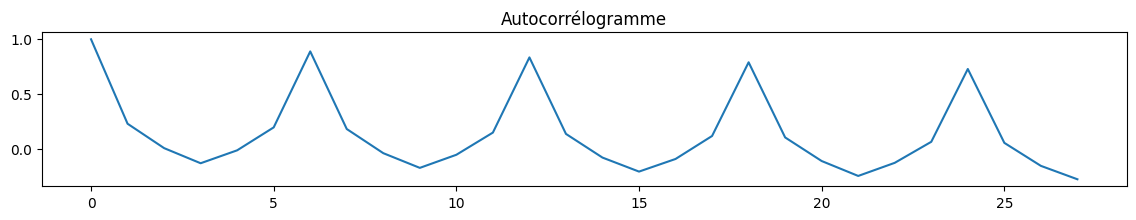

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(14, 2))
cor = acf(df_nosunday.value)
ax.plot(cor)
ax.set_title("Autocorrélogramme");

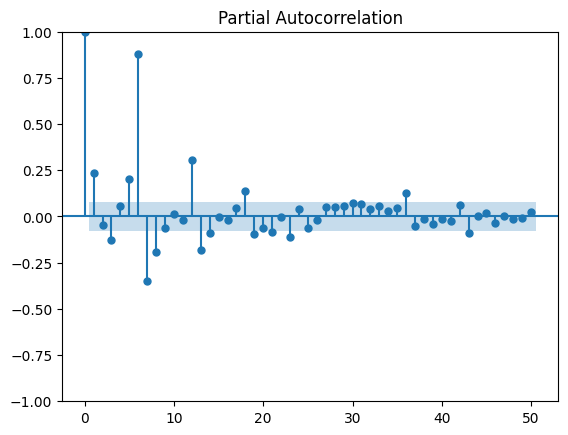

In [19]:
plot_pacf(df_nosunday.value, lags=50);

On décompose la série en tendance + saisonnalité. Les étés et Noël apparaissent.

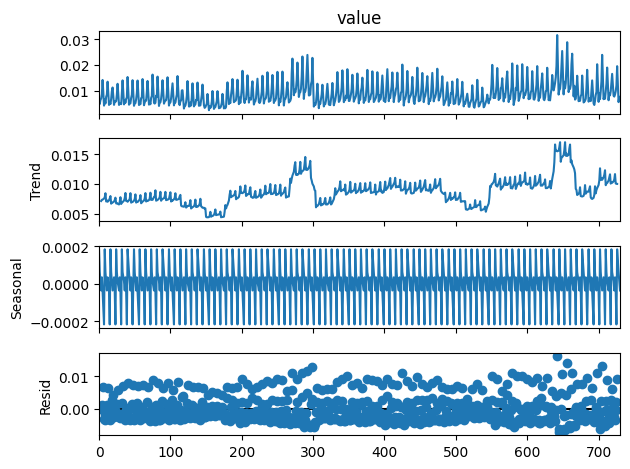

In [21]:
from statsmodels.tsa.seasonal import seasonal_decompose

res = seasonal_decompose(df_nosunday.value, period=7)
res.plot();

Text(0.5, 1.0, 'Saisonnalité')

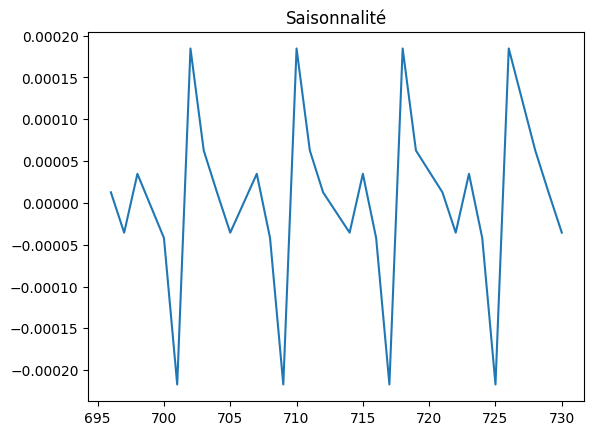

In [22]:
plt.plot(res.seasonal[-30:])
plt.title("Saisonnalité")

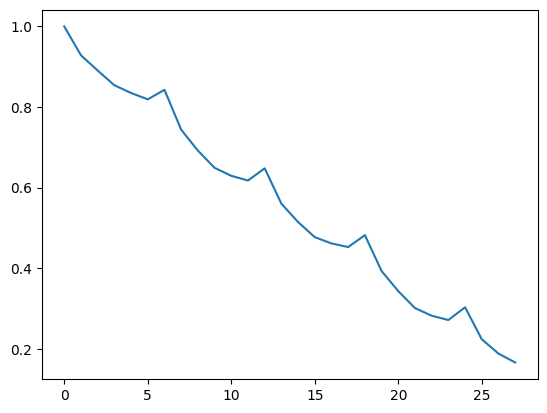

In [24]:
cor = acf(res.trend[5:-5], fft=True)
plt.plot(cor)

On cherche maintenant la saisonnalité de la série débarrassée de sa tendance herbdomadaire. On retrouve la saisonnalité mensuelle.

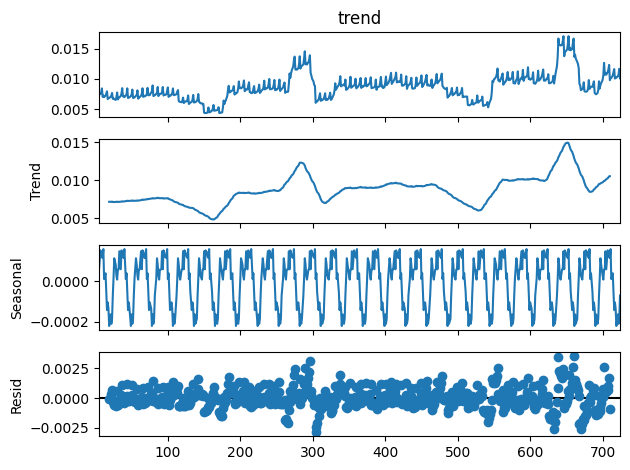

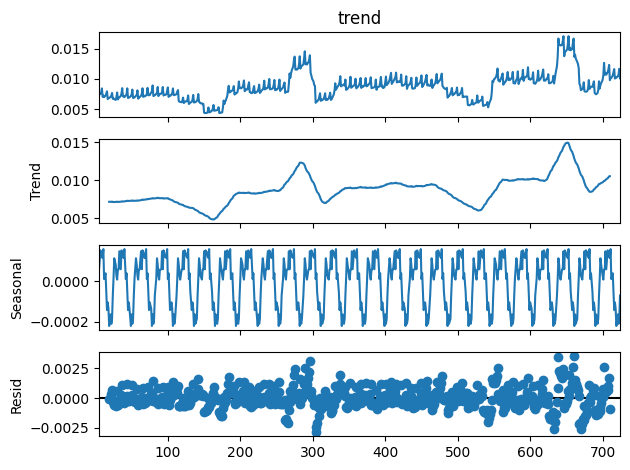

In [25]:
res_year = seasonal_decompose(res.trend[5:-5], period=25)
res_year.plot()

## Test de stationnarité

Le test [KPSS](https://en.wikipedia.org/wiki/KPSS_test) permet de tester la stationnarité d'une série.

In [26]:
from statsmodels.tsa.stattools import kpss

kpss(res.trend[5:-5])

/tmp/ipykernel_59627/406539216.py:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss(res.trend[5:-5])


(np.float64(1.245031416161398),
 np.float64(0.01),
 16,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

Comme ce n'est pas toujours facile à interpréter, on simule une variable aléatoire gaussienne donc sans tendance.

In [27]:
from numpy.random import randn

bruit = randn(1000)
kpss(bruit)

/tmp/ipykernel_59627/3765297593.py:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss(bruit)


(np.float64(0.11384797070848017),
 np.float64(0.1),
 1,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

Et puis une série avec une tendance forte.

In [28]:
from numpy.random import randn
from numpy import arange

bruit = randn(1000) * 100 + arange(1000) / 10
kpss(bruit)

/tmp/ipykernel_59627/2615492180.py:4: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss(bruit)


(np.float64(4.201503723150045),
 np.float64(0.01),
 11,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

Une valeur forte indique une tendance et la série en a clairement une.

## Prédiction

Les modèles *AR*, *ARMA*, *ARIMA* se concentrent sur une série à une dimension. En machine learning, il y a la série et plein d'autres informations. On construit une matrice avec des séries décalées.

In [29]:
from statsmodels.tsa.tsatools import lagmat

lag = 8
X = lagmat(df_nosunday["value"], lag)
lagged = df_nosunday.copy()
for c in range(1, lag + 1):
    lagged["lag%d" % c] = X[:, c - 1]
lagged.tail()

,date,value,notrend,trend,weekday,lag1,lag2,lag3,lag4,lag5,lag6,lag7,lag8
725,2025-02-28 00:39:51.820916,0.011877,0.002777,0.009100,4,0.009749,0.008428,0.007654,0.007989,0.016468,0.013102,0.009676,0.008109
726,2025-03-01 00:39:51.820916,0.019454,0.010350,0.009105,5,0.011877,0.009749,0.008428,0.007654,0.007989,0.016468,0.013102,0.009676
728,2025-03-03 00:39:51.820916,0.005494,-0.003620,0.009114,0,0.019454,0.011877,0.009749,0.008428,0.007654,0.007989,0.016468,0.013102
729,2025-03-04 00:39:51.820916,0.007479,-0.001639,0.009118,1,0.005494,0.019454,0.011877,0.009749,0.008428,0.007654,0.007989,0.016468
730,2025-03-05 00:39:51.820916,0.007589,-0.001534,0.009123,2,0.007479,0.005494,0.019454,0.011877,0.009749,0.008428,0.007654,0.007989


On ajoute ou on réécrit le jour de la semaine qu'on utilise comme variable supplémentaire.

In [30]:
lagged["weekday"] = lagged.date.dt.weekday

In [31]:
X = lagged.drop(["date", "value", "notrend", "trend"], axis=1)
Y = lagged["value"]
X.shape, Y.shape

((627, 9), (627,))

In [32]:
from numpy import corrcoef

corrcoef(X)

/home/xadupre/vv/this312/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/xadupre/vv/this312/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


array([[        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,  1.        ,  0.99999247, ..., -0.69791204,
         0.99986414,  0.99996236],
       [        nan,  0.99999247,  1.        , ..., -0.69925528,
         0.99991238,  0.99996712],
       ...,
       [        nan, -0.69791204, -0.69925528, ...,  1.        ,
        -0.70192748, -0.70219418],
       [        nan,  0.99986414,  0.99991238, ..., -0.70192748,
         1.        ,  0.99987949],
       [        nan,  0.99996236,  0.99996712, ..., -0.70219418,
         0.99987949,  1.        ]], shape=(627, 627))

Etrange autant de grandes valeurs, cela veut dire que la tendance est trop forte pour calculer des corrélations, il vaudrait mieux tout recommencer avec la série $\Delta Y_t = Y_t - Y_{t-1}$. Bref, passons...

In [33]:
X.columns

Index(['weekday', 'lag1', 'lag2', 'lag3', 'lag4', 'lag5', 'lag6', 'lag7',
       'lag8'],
      dtype='object')

Une régression linéaire car les modèles linéaires sont toujours de bonnes baseline et pour connaître le modèle simulé, on ne fera pas beaucoup mieux.

In [34]:
from sklearn.linear_model import LinearRegression

clr = LinearRegression()
clr.fit(X, Y)

LinearRegression()

In [35]:
from sklearn.metrics import r2_score

r2_score(Y, clr.predict(X))

0.8750652931937053

In [36]:
clr.coef_

array([ 0.00171654,  0.35489858,  0.2667268 ,  0.07460985,  0.01104078,
       -0.06234941,  0.37933643, -0.12027835, -0.05625968])

On retrouve la saisonnalité, $Y_t$ et $Y_{t-6}$ sont de mèches.

In [37]:
for i in range(1, X.shape[1]):
    print("X(t-%d)" % (i), r2_score(Y, X.iloc[:, i]))

X(t-1) -0.5343370770216411
X(t-2) -0.9776153682766282
X(t-3) -1.2540090159405772
X(t-4) -1.01367860631983
X(t-5) -0.602451646171541
X(t-6) 0.7635187615860253
X(t-7) -0.6454355106118854
X(t-8) -1.0867844309933337


Auparavant (l'année dernière en fait), je construisais deux bases, apprentissage et tests, comme ceci :

In [38]:
n = X.shape[0]
X_train = X.iloc[: n * 2 // 3]
X_test = X.iloc[n * 2 // 3 :]
Y_train = Y[: n * 2 // 3]
Y_test = Y[n * 2 // 3 :]

Et puis *scikit-learn* est arrivée avec [TimeSeriesSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html).

In [39]:
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=5)
for train_index, test_index in tscv.split(lagged):
    data_train, data_test = lagged.iloc[train_index, :], lagged.iloc[test_index, :]
    print("TRAIN:", data_train.shape, "TEST:", data_test.shape)

TRAIN: (107, 13) TEST: (104, 13)
TRAIN: (211, 13) TEST: (104, 13)
TRAIN: (315, 13) TEST: (104, 13)
TRAIN: (419, 13) TEST: (104, 13)
TRAIN: (523, 13) TEST: (104, 13)


Et on calé une forêt aléatoire...

In [40]:
import warnings
from sklearn.ensemble import RandomForestRegressor

clr = RandomForestRegressor()


def train_test(clr, train_index, test_index):
    data_train = lagged.iloc[train_index, :]
    data_test = lagged.iloc[test_index, :]
    clr.fit(
        data_train.drop(["value", "date", "notrend", "trend"], axis=1), data_train.value
    )
    r2 = r2_score(
        data_test.value,
        clr.predict(
            data_test.drop(["value", "date", "notrend", "trend"], axis=1).values
        ),
    )
    return r2


warnings.simplefilter("ignore")
last_test_index = None
for train_index, test_index in tscv.split(lagged):
    r2 = train_test(clr, train_index, test_index)
    if last_test_index is not None:
        r2_prime = train_test(clr, last_test_index, test_index)
        print(r2, r2_prime)
    else:
        print(r2)
    last_test_index = test_index

0.7830797306279333
0.7892143392871785 0.710251489079545
0.926515934247996 0.9254337080628354
0.811090703869577 0.7717494202307796
0.7646201099598264 0.6571969210691542


2 ans coupé en 5, soit tous les 5 mois, ça veut dire que ce découpage inclut parfois Noël, parfois l'été et que les performances y seront très sensibles.

In [41]:
from sklearn.metrics import r2_score

r2 = r2_score(
    data_test.value,
    clr.predict(data_test.drop(["value", "date", "notrend", "trend"], axis=1).values),
)
r2

0.6571969210691542

On compare avec le $r_2$ avec le même $r_2$ obtenu en utilisant $Y_{t-1}$, $Y_{t-2}$, ... $Y_{t-d}$ comme prédiction.

In [42]:
for i in range(1, 9):
    print(i, ":", r2_score(data_test.value, data_test["lag%d" % i]))

1 : -0.5315727068325993
2 : -1.0250735581487076
3 : -1.3208901364676007
4 : -1.074139284130378
5 : -0.6238251202278204
6 : 0.657764576444329
7 : -0.7208207891388771
8 : -1.1824818758877917


In [43]:
lagged[:5]

,date,value,notrend,trend,weekday,lag1,lag2,lag3,lag4,lag5,lag6,lag7,lag8
0,2023-03-06 00:39:51.820916,0.005036,-0.000797,0.005833,0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
1,2023-03-07 00:39:51.820916,0.004769,-0.001068,0.005837,1,0.005036,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
2,2023-03-08 00:39:51.820916,0.006293,0.000451,0.005842,2,0.004769,0.005036,0.000000,0.000000,0.0,0.0,0.0,0.0
3,2023-03-09 00:39:51.820916,0.006932,0.001086,0.005846,3,0.006293,0.004769,0.005036,0.000000,0.0,0.0,0.0,0.0
4,2023-03-10 00:39:51.820916,0.008666,0.002815,0.005851,4,0.006932,0.006293,0.004769,0.005036,0.0,0.0,0.0,0.0


En fait le jour de la semaine est une variable catégorielle, on crée une colonne par jour.

In [44]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

In [45]:
cols = ["lag1", "lag2", "lag3", "lag4", "lag5", "lag6", "lag7", "lag8"]
ct = ColumnTransformer(
    [("pass", "passthrough", cols), ("dummies", OneHotEncoder(), ["weekday"])]
)
pred = ct.fit(lagged).transform(lagged[:5])
pred

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 1.        , 0.        ,
        0.        , 0.        , 0.        , 0.        ],
       [0.00503561, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 1.        ,
        0.        , 0.        , 0.        , 0.        ],
       [0.00476948, 0.00503561, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        1.        , 0.        , 0.        , 0.        ],
       [0.00629279, 0.00476948, 0.00503561, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 1.        , 0.        , 0.        ],
       [0.00693242, 0.00629279, 0.00476948, 0.00503561, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 1.        , 0.        ]])

On met tout dans un pipeline parce que c'est plus joli, plus pratique aussi.

In [46]:
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA, TruncatedSVD

cols = ["lag1", "lag2", "lag3", "lag4", "lag5", "lag6", "lag7", "lag8"]
model = make_pipeline(
    make_pipeline(
        ColumnTransformer(
            [
                ("pass", "passthrough", cols),
                (
                    "dummies",
                    make_pipeline(OneHotEncoder(), TruncatedSVD(n_components=2)),
                    ["weekday"],
                ),
            ]
        ),
        LinearRegression(),
    )
)
model.fit(lagged, lagged["value"])

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('columntransformer',
                                  ColumnTransformer(transformers=[('pass',
                                                                   'passthrough',
                                                                   ['lag1',
                                                                    'lag2',
                                                                    'lag3',
                                                                    'lag4',
                                                                    'lag5',
                                                                    'lag6',
                                                                    'lag7',
                                                                    'lag8']),
                                                                  ('dummies',
                                                                   Pipeline(steps=[('onehotencoder',
                                                                                    OneHotEncoder()),
                                                                                   ('truncatedsvd',
                                                                                    TruncatedSVD())]),
                                                                   ['weekday'])])),
                                 ('linearregression', LinearRegression())]))])

C'est plus facile à voir visuellement.

In [47]:
r2_score(lagged["value"], model.predict(lagged))

0.8302843587445363